# Código Ramdom Forest trabajo evaluativo 1 Aprendizaje Automático
Liceth Mosquera

In [11]:
import numpy as np
import pandas as pd
import itertools as it
# from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from Orange.classification import tree
# https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier
from sklearn.datasets import fetch_mldata
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
from pprint import pprint


import matplotlib.pyplot as plt
#%matplotlib inline

In [12]:
Data = pd.read_excel('Data.xlsx')
Data = Data.set_index('Date')
#Data.isnull().any()
#Data = Data.fillna(method='ffill')
df1 = Data.dropna(axis=0,how='any')
Y = df1['Class']
X = df1.drop('Class', axis = 1)
df1.groupby('Class').size()

Class
-1    1111
 0    2001
 1     963
dtype: int64

In [13]:
Hpyer_Parameters = [[1,2,3,4,5,6,7,8,9],[4,5,6]]
set_parameters = [i for i in it.product(*Hpyer_Parameters)]

Epsilon = 0.2
delta = 0.1

## 5. Dividir el conjunto de muestra en: entrenamiento, validación y prueba.

In [14]:
X1_tr, X1_o, Y1_tr, Y1_o = train_test_split(X, Y, test_size=0.4, train_size = 0.6,random_state=19)
X1_va, X1_ts, Y1_va, Y1_ts = train_test_split(X1_o, Y1_o, test_size=0.5,train_size = 0.5, random_state=19)

In [15]:
rf = RandomForestClassifier(random_state = 42)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [16]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = OneVsRestClassifier(RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1))
# Fit the random search model
rf_random.fit(X1_tr, Y1_tr)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.6min


In [13]:
def evaluate(model, X1_tr, Y1_tr):
    predictions = model.predict(X1_ts)
    errors = abs(predictions - Y1_ts)
    mape = 100 * np.mean(errors / Y1_ts)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [15]:
evaluate(rf_random,X1_o, Y1_o)


Model Performance
Average Error: 0.4314 degrees.
Accuracy = -inf%.


-inf

In [20]:
base_model = OneVsRestClassifier(RandomForestClassifier(n_estimators = 1000, random_state = 400))
base_model.fit(X1_tr, Y1_tr)
base_accuracy = evaluate(rf_random,X1_o, Y1_o)

Model Performance
Average Error: 0.4314 degrees.
Accuracy = -inf%.


# Para un boque en parqicular con 50 arboles de profundidad 3

In [29]:
# Binarize the output
y = label_binarize(Y, classes=[-1, 0, 1])
n_classes = y.shape[1]
n_classes

3

In [30]:
Xl_tr, X_ts, Yl_tr, Y_ts = train_test_split(X, y, test_size=0.6, train_size = 0.4,random_state=19)
Xl_va, Xl_ts, Yl_va, Yl_ts = train_test_split(X_ts, Y_ts, test_size=0.5,train_size = 0.5, random_state=19)

In [31]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=50, max_depth=3,random_state=0))
clf.fit(Xl_tr, Yl_tr)
y_score = clf.predict_proba(Xl_ts)

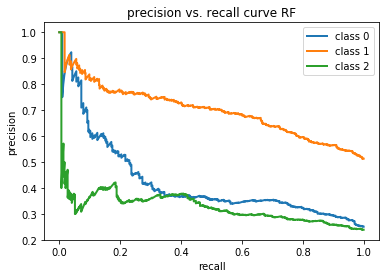

In [35]:
# precision recall curve
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Yl_ts[:, i], y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve RF")
plt.show()

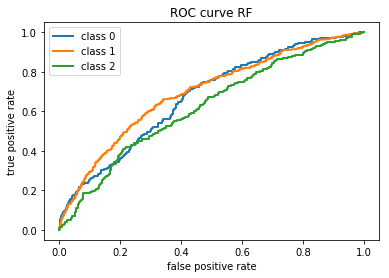

In [34]:
# roc curve
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Yl_ts[:, i],y_score[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve RF")
plt.show()

In [38]:
Epsilon = 0.2 #error real
delta = 0.1  #error de entrenamiento
step=10
h_aprox = len(set_parameters) #hipotesis para una regresión linealn_est = int(np.ceil((1/Epsilon)*(np.log(len(set_parameters)) + np.log(1/delta))))
n=100

In [39]:
from sklearn.model_selection import cross_val_score
Accuracy= []
scores=[]
RF_m=RandomForestClassifier(n_estimators=50, max_depth=3,random_state=0) 
for i in range (n,int(len(df1)*0.6),step):
    X1_tr, X1_t, Y1_tr, Y1_t = train_test_split(X, Y,test_size= i/X.shape[0]*0.4/0.6, train_size = i/X.shape[0], random_state=19)
    X1_va, X1_ts, Y1_va, Y1_ts = train_test_split(X1_t, Y1_t, test_size = 0.5, train_size = 0.5, random_state=19)
    model = RF_m.fit(X1_tr, Y1_tr)
    predictions = RF_m.predict(X1_ts)
    Accuracy.append(RF_m.score(X1_ts, Y1_ts))
    scores.append(cross_val_score(RF_m, X1_ts, Y1_ts, cv=3))
len(Accuracy)

235

In [40]:
max(Accuracy)

0.6493506493506493

In [41]:
n_bst = np.where(Accuracy == np.amax(Accuracy))[0]
n_bst

array([13], dtype=int64)

In [42]:
M_N=n+n_bst[0]*step
n_bst
print('El tamaño de los datos para entrenar con el que se obtiene el mejor modelo es {0}'.format(M_N))

El tamaño de los datos para entrenar con el que se obtiene el mejor modelo es 230


In [43]:
a = []
for i in range(0,len(Accuracy)): #len(N)-1
    i=n+i*step
    a.append(i)
#print(a)

Text(0.5, 0, 'Cantidad datos')

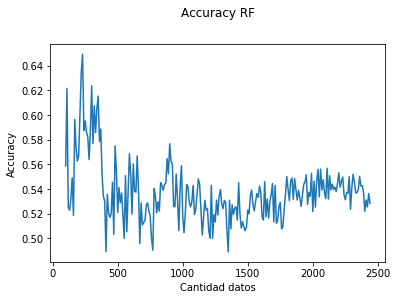

In [44]:
plt.plot(a,Accuracy)
plt.title('Accuracy RF', y=1.1)
plt.ylabel('Accuracy')
plt.xlabel('Cantidad datos')